# Deploying an Intraday Trading Agent

Regardless of which timeframe would make most sense to trade on, an intraday timeframe will be considered for this exercise so that the task can be completed in a reasonable time. Specifically we will be trading on a 1-minute timeframe. We use Oanda as our trading platform, which allows us to place trades in Python using a paper trading account. This allows us to achieve a very realistic trading environment for our exercise - deploying a live trading bot would only be a matter of changing the API credentials to that of a live account..


In [161]:
%matplotlib widget
import os
import numpy as np
import pandas as pd
from pylab import plt
from pprint import pprint
plt.style.use('seaborn-v0_8')
pd.set_option('mode.chained_assignment', None)
pd.set_option ('display.float_format', '{:.5f}'. format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

# Select Keras backend
import os
# os.environ['KERAS_BACKEND'] = 'jax'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# The Oanada API

In [162]:
import tpqoa
api = tpqoa.tpqoa('../oanda.cfg')
ins = api.get_instruments()
ins

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD'),
 ('AUD/SGD', 'AUD_SGD'),
 ('AUD/USD', 'AUD_USD'),
 ('Australia 200', 'AU200_AUD'),
 ('Brent Crude Oil', 'BCO_USD'),
 ('Bund', 'DE10YB_EUR'),
 ('CAD/CHF', 'CAD_CHF'),
 ('CAD/HKD', 'CAD_HKD'),
 ('CAD/JPY', 'CAD_JPY'),
 ('CAD/SGD', 'CAD_SGD'),
 ('CHF/HKD', 'CHF_HKD'),
 ('CHF/JPY', 'CHF_JPY'),
 ('CHF/ZAR', 'CHF_ZAR'),
 ('China A50', 'CN50_USD'),
 ('China H Shares', 'CHINAH_HKD'),
 ('Copper', 'XCU_USD'),
 ('Corn', 'CORN_USD'),
 ('EUR/AUD', 'EUR_AUD'),
 ('EUR/CAD', 'EUR_CAD'),
 ('EUR/CHF', 'EUR_CHF'),
 ('EUR/CZK', 'EUR_CZK'),
 ('EUR/DKK', 'EUR_DKK'),
 ('EUR/GBP', 'EUR_GBP'),
 ('EUR/HKD', 'EUR_HKD'),
 ('EUR/HUF', 'EUR_HUF'),
 ('EUR/JPY', 'EUR_JPY'),
 ('EUR/NOK', 'EUR_NOK'),
 ('EUR/NZD', 'EUR_NZD'),
 ('EUR/PLN', 'EUR_PLN'),
 ('EUR/SEK', 'EUR_SEK'),
 ('EUR/SGD', 'EUR_SGD'),
 ('EUR/TRY', 'EUR_TRY'),
 ('EUR/USD', 'EUR_USD'),
 ('EUR/ZAR', 'EUR_ZAR'),
 ('Europe 50', 'EU50_EUR

In [163]:
# This gathers some 1-minute data from 2020

raw_data = api.get_history(instrument='EUR_USD', start='2020-02-01', end='2020-02-29', granularity='M1', price='M')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27652 entries, 2020-02-02 22:00:00 to 2020-02-28 21:59:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         27652 non-null  float64
 1   h         27652 non-null  float64
 2   l         27652 non-null  float64
 3   c         27652 non-null  float64
 4   volume    27652 non-null  int64  
 5   complete  27652 non-null  bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 1.3 MB


In [164]:
raw_data.head()

,o,h,l,c,volume,complete
time,,,,,,
2020-02-02 22:00:00,1.10956,1.10956,1.10951,1.10951,3,True
2020-02-02 22:01:00,1.10948,1.10948,1.10940,1.10940,3,True
2020-02-02 22:02:00,1.10940,1.10940,1.10939,1.10939,2,True
2020-02-02 22:03:00,1.10934,1.10934,1.10930,1.10930,2,True
2020-02-02 22:06:00,1.10928,1.10931,1.10928,1.10931,2,True


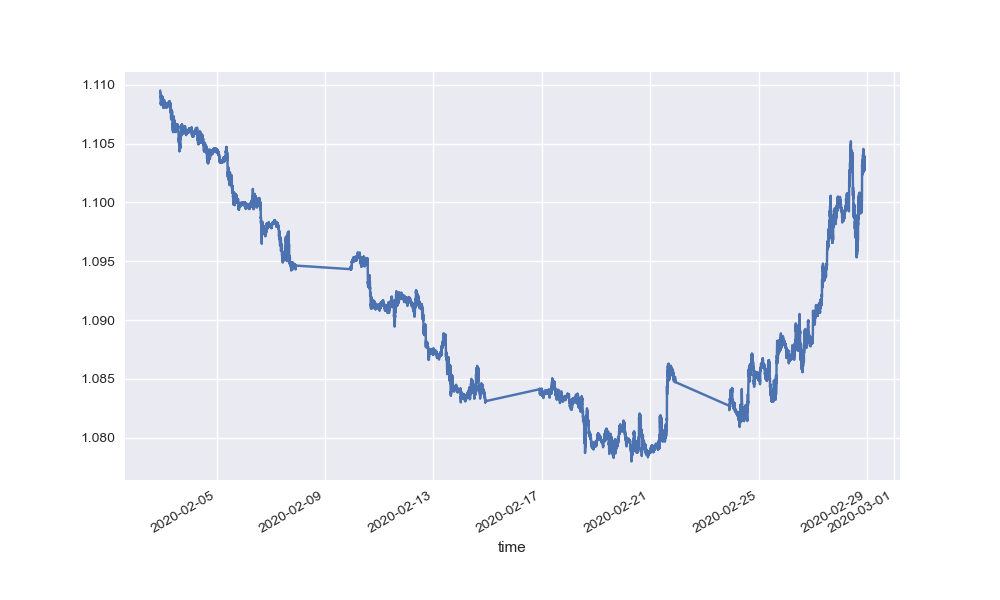

In [165]:
raw_data['c'].plot(figsize=(10, 6));

Data can be streamed from the Oanda platform. This is useful for deployment.

In [166]:
api.stream_data('EUR_USD', stop=10)

2024-07-05T14:14:40.496722363Z 1.08164 1.08172
2024-07-05T14:14:40.914742690Z 1.08163 1.08171
2024-07-05T14:14:41.606705671Z 1.08163 1.0817
2024-07-05T14:14:42.422431892Z 1.08161 1.0817
2024-07-05T14:14:43.512146166Z 1.08162 1.08169
2024-07-05T14:14:43.737609733Z 1.0816 1.08168
2024-07-05T14:14:46.365681773Z 1.08157 1.08166
2024-07-05T14:14:46.504529537Z 1.08157 1.08165
2024-07-05T14:14:46.685824086Z 1.0816 1.08166
2024-07-05T14:14:47.379097604Z 1.08159 1.08165


We can create (and cancel) orders using the Oanda API.

In [169]:
def print_details(order):
  # Reduce the amount of information printed
  return order['time'], order['instrument'], order['units'], order['price'], order['pl']


In [170]:
order = api.create_order('EUR_USD', units=25000, suppress=True, ret=True)
pprint(order)

print_details(order)


{'accountBalance': '100553.7585',
 'accountID': '101-004-28878656-001',
 'batchID': '2444',
 'commission': '0.0',
 'financing': '0.0',
 'fullPrice': {'asks': [{'liquidity': '475000', 'price': 1.08161},
                        {'liquidity': '500000', 'price': 1.08162},
                        {'liquidity': '2000000', 'price': 1.08163},
                        {'liquidity': '2000000', 'price': 1.08164},
                        {'liquidity': '5000000', 'price': 1.08165}],
               'bids': [{'liquidity': '500000', 'price': 1.08154},
                        {'liquidity': '2500000', 'price': 1.08153},
                        {'liquidity': '2000000', 'price': 1.08152},
                        {'liquidity': '5000000', 'price': 1.08151}],
               'closeoutAsk': 1.08183,
               'closeoutBid': 1.08132,
               'type': 'PRICE'},
 'fullVWAP': 1.08161,
 'gainQuoteHomeConversionFactor': '0.777784296173',
 'guaranteedExecutionFee': '0.0',
 'halfSpreadCost': '0.684',
 'id': 

('2024-07-05T14:17:08.551671504Z', 'EUR_USD', '25000.0', 1.08161, '-167.1367')

To close the position we simply reverse the sign on our order.

In [171]:
order = api.create_order('EUR_USD', units=-25000, suppress=True, ret=True)
print_details(order)

('2024-07-05T14:17:11.477740931Z', 'EUR_USD', '-25000.0', 1.08155, '0.0')

We can also submit orders with stop losses, or trailing stop losses.

In [173]:
sl_order = api.create_order('EUR_USD', units=25000, sl_distance=0.005, suppress=True, ret=True)
print_details(sl_order)

('2024-07-05T14:17:34.411647452Z', 'EUR_USD', '25000.0', 1.08145, '0.0')

In [174]:
tsl_order = api.create_order('EUR_USD', units=25000, tsl_distance=0.005, suppress=True, ret=True)
print_details(tsl_order)

('2024-07-05T14:17:38.480116481Z', 'EUR_USD', '25000.0', 1.08141, '0.0')

Order with a take profit target:

In [185]:
tp_order = api.create_order('EUR_USD', units=25000, tp_price=order['price'] + 0.001, suppress=True, ret=True)
print(tp_order['time'], tp_order['instrument'], tp_order['units'])

2024-07-05T14:20:28.432055399Z EUR_USD 25000.0


Print a summary of recent transactions:

In [12]:
api.print_transactions(tid=int(order['id'])-22)

 388 | 2024-06-19T07:50:35.47 | EUR_USD |  50000.0 |  -0.9871
 390 | 2024-06-19T07:50:40.81 | EUR_USD | -50000.0 |  -1.3819
 392 | 2024-06-19T07:50:46.25 | EUR_USD |  50000.0 |  -1.5793
 394 | 2024-06-19T07:51:06.46 | EUR_USD | -50000.0 |  -0.3948
 396 | 2024-06-19T07:51:46.15 | EUR_USD |  25000.0 |  -1.1845
 398 | 2024-06-19T18:46:44.62 | EUR_USD | -25000.0 |      0.0
 400 | 2024-06-19T18:52:01.07 | EUR_USD |  50000.0 |  -0.3952
 402 | 2024-06-19T18:52:06.35 | EUR_USD | -50000.0 |  -1.1856
 405 | 2024-06-20T09:14:07.84 | EUR_USD |  25000.0 |  39.7585
 407 | 2024-06-20T11:09:21.93 | EUR_USD |  25000.0 |      0.0
 409 | 2024-06-20T11:09:22.23 | EUR_USD | -25000.0 |  -1.5835
 411 | 2024-06-20T11:09:22.50 | EUR_USD |  25000.0 |      0.0
 414 | 2024-06-20T11:09:22.63 | EUR_USD |  25000.0 |      0.0


In [13]:
api.get_account_summary()

{'id': '101-004-28878656-001',
 'alias': 'Primary',
 'currency': 'GBP',
 'balance': '99772.3496',
 'createdByUserID': 28878656,
 'createdTime': '2024-04-13T13:34:43.181204491Z',
 'guaranteedStopLossOrderMode': 'ALLOWED',
 'pl': '-228.0246',
 'resettablePL': '-228.0246',
 'resettablePLTime': '0',
 'financing': '0.3742',
 'commission': '0.0',
 'guaranteedExecutionFees': '0.0',
 'marginRate': '0.03333333333333',
 'openTradeCount': 2,
 'openPositionCount': 1,
 'pendingOrderCount': 2,
 'hedgingEnabled': False,
 'unrealizedPL': '-2.3752',
 'NAV': '99769.9744',
 'marginUsed': '1409.1167',
 'marginAvailable': '98360.8693',
 'positionValue': '42273.5',
 'marginCloseoutUnrealizedPL': '-1.1817',
 'marginCloseoutNAV': '99771.1679',
 'marginCloseoutMarginUsed': '1409.1167',
 'marginCloseoutPercent': '0.00706',
 'marginCloseoutPositionValue': '42273.5',
 'withdrawalLimit': '98360.8693',
 'marginCallMarginUsed': '1409.1167',
 'marginCallPercent': '0.01412',
 'lastTransactionID': '416'}

In [14]:
# Close out all open positions
# order = api.create_order('EUR_USD', units=-25000, suppress=True, ret=True)
# print_details(order)

# Setting an Environment

We use a OpenAI gym-like environment that is integrated with the Oanda API, with the class is defined in `oandaenv.py`.

In [187]:
import sys
sys.path.insert(0, './5. Deep Reinforcement Learning')

import oandaenv as oe
import importlib
importlib.reload(oe)

<module 'oandaenv' from '/Users/dev/QuantConcepts/5. Deep Reinforcement Learning/oandaenv.py'>

In the following steps we download EUR_USD timeseries data which will form our train/validate/test split.

In [188]:
symbol = 'EUR_USD'
start_datetime = '2024-05-01 05:00:00'
learn_val_split = '2024-05-15 05:00:00'
val_test_split = '2024-05-22 05:00:00'
end_datetime = '2024-05-29 05:00:00'
lags = 6
granularity='M5'

In [189]:
%time
learn_env = oe.OandaEnv(
    symbol=symbol,
    start=start_datetime,
    end=learn_val_split,
    granularity=granularity,
    price='M',
    features=[symbol, 'r', 's', 'm', 'v'],
    window=10,
    lags=lags,
    leverage=20,
    min_accuracy=0.4,
    min_performance=0.8
  )

learn_env.data.info()

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 11 µs
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2869 entries, 2024-05-01 05:50:00 to 2024-05-15 04:55:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2869 non-null   float64
 1   r        2869 non-null   float64
 2   s        2869 non-null   float64
 3   m        2869 non-null   float64
 4   v        2869 non-null   float64
 5   d        2869 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 156.9 KB


In [190]:
learn_env.data.head(), learn_env.data.tail()

(                     EUR_USD        r       s        m       v  d
 time                                                             
 2024-05-01 05:50:00  1.06560  0.00006 1.06556  0.00000 0.00007  1
 2024-05-01 05:55:00  1.06556 -0.00004 1.06555 -0.00001 0.00007  0
 2024-05-01 06:00:00  1.06550 -0.00006 1.06554 -0.00001 0.00007  0
 2024-05-01 06:05:00  1.06554  0.00004 1.06554 -0.00001 0.00007  1
 2024-05-01 06:10:00  1.06555  0.00001 1.06554  0.00000 0.00007  1,
                      EUR_USD        r       s        m       v  d
 time                                                             
 2024-05-15 04:35:00  1.08216 -0.00010 1.08243 -0.00004 0.00005  0
 2024-05-15 04:40:00  1.08220  0.00004 1.08238 -0.00004 0.00005  1
 2024-05-15 04:45:00  1.08217 -0.00003 1.08234 -0.00004 0.00005  0
 2024-05-15 04:50:00  1.08210 -0.00006 1.08230 -0.00004 0.00004  0
 2024-05-15 04:55:00  1.08216  0.00006 1.08227 -0.00003 0.00005  1)

In [191]:
%time
valid_env = oe.OandaEnv(
    symbol=learn_env.symbol,
    start=learn_val_split,
    end=val_test_split,
    granularity=learn_env.granularity,
    price=learn_env.price,
    features=learn_env.features,
    window=learn_env.window,
    lags=learn_env.lags,
    leverage=learn_env.leverage,
    min_accuracy=learn_env.min_accuracy,
    min_performance=learn_env.min_performance,
    mu=learn_env.mu,
    std=learn_env.std
  )

valid_env.data.info()

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 12.2 µs
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1395 entries, 2024-05-15 05:50:00 to 2024-05-22 04:55:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  1395 non-null   float64
 1   r        1395 non-null   float64
 2   s        1395 non-null   float64
 3   m        1395 non-null   float64
 4   v        1395 non-null   float64
 5   d        1395 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 76.3 KB


In [192]:
valid_env.data.head(), valid_env.data.tail()

(                     EUR_USD        r       s       m       v  d
 time                                                            
 2024-05-15 05:50:00  1.08253  0.00011 1.08235 0.00003 0.00007  1
 2024-05-15 05:55:00  1.08271  0.00017 1.08240 0.00004 0.00009  1
 2024-05-15 06:00:00  1.08281  0.00009 1.08244 0.00004 0.00008  1
 2024-05-15 06:05:00  1.08266 -0.00014 1.08247 0.00003 0.00010  0
 2024-05-15 06:10:00  1.08258 -0.00007 1.08249 0.00002 0.00010  0,
                      EUR_USD        r       s        m       v  d
 time                                                             
 2024-05-22 04:35:00  1.08533 -0.00010 1.08544 -0.00001 0.00007  0
 2024-05-22 04:40:00  1.08533  0.00000 1.08543 -0.00001 0.00007  0
 2024-05-22 04:45:00  1.08536  0.00003 1.08541 -0.00002 0.00006  1
 2024-05-22 04:50:00  1.08542  0.00006 1.08539 -0.00001 0.00006  1
 2024-05-22 04:55:00  1.08536 -0.00006 1.08539 -0.00001 0.00006  0)

In [193]:
%time
test_env = oe.OandaEnv(
    symbol=learn_env.symbol,
    start=val_test_split,
    end=end_datetime,
    granularity=learn_env.granularity,
    price=learn_env.price,
    features=learn_env.features,
    window=learn_env.window,
    lags=learn_env.lags,
    leverage=learn_env.leverage,
    min_accuracy=learn_env.min_accuracy,
    min_performance=learn_env.min_performance,
    mu=learn_env.mu,
    std=learn_env.std
  )

test_env.data.info()

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 11.9 µs
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1430 entries, 2024-05-22 05:50:00 to 2024-05-29 04:55:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  1430 non-null   float64
 1   r        1430 non-null   float64
 2   s        1430 non-null   float64
 3   m        1430 non-null   float64
 4   v        1430 non-null   float64
 5   d        1430 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 78.2 KB


In [194]:
test_env.data.head(), test_env.data.tail()

(                     EUR_USD        r       s       m       v  d
 time                                                            
 2024-05-22 05:50:00  1.08560  0.00002 1.08545 0.00002 0.00006  1
 2024-05-22 05:55:00  1.08560  0.00000 1.08548 0.00003 0.00005  0
 2024-05-22 06:00:00  1.08574  0.00013 1.08553 0.00005 0.00005  1
 2024-05-22 06:05:00  1.08568 -0.00006 1.08557 0.00004 0.00006  0
 2024-05-22 06:10:00  1.08568  0.00000 1.08560 0.00003 0.00006  0,
                      EUR_USD        r       s        m       v  d
 time                                                             
 2024-05-29 04:35:00  1.08462  0.00006 1.08458 -0.00001 0.00007  1
 2024-05-29 04:40:00  1.08468  0.00006 1.08456 -0.00001 0.00007  1
 2024-05-29 04:45:00  1.08465 -0.00003 1.08456 -0.00001 0.00007  0
 2024-05-29 04:50:00  1.08467  0.00002 1.08457  0.00001 0.00005  1
 2024-05-29 04:55:00  1.08478  0.00010 1.08460  0.00003 0.00005  1)

Let us now visualize our training, validation and testing datasets.

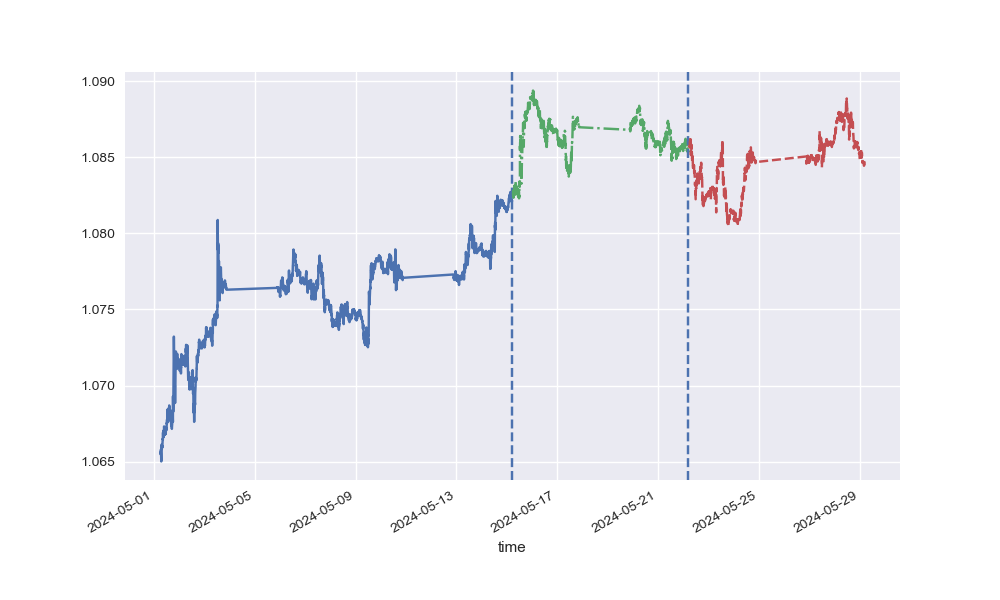

In [195]:
import matplotlib.pyplot as plt

plt.clf()
ax = learn_env.data[learn_env.symbol].plot(figsize=(10, 6))
plt.axvline(learn_env.data.index[-1], ls='--')
valid_env.data[learn_env.symbol].plot(ax=ax, style='-.')
plt.axvline(valid_env.data.index[-1], ls='--')
test_env.data[learn_env.symbol].plot(ax=ax, style='--')
plt.show()

# Trading Agent

## Simplifying Assumptions

To simplify the problem on this initial pass, and make the problem tractable in a single Jupyter notebook, some simplifying assumptions are made:
  * **Transaction costs:** We do not consider the effect of transaction costs in our results. When trading on a short time-frame like 5s, it is highly likely the transaction costs would overwhelm profits achieved in practice. To avoid that problem, one would have to consider longer timescales.
	* **Risk management:** We will not use stop-loss trades or trailing-stop-loss trades, which could be useful to experiment with.

## Features

In addition to the points above, we only use previous returns data as a feature for our model. Adding more features to the model would clearly be a way to improve teh performance, and this is in no way an attempt to create an optimal/performant trading agent. 

Some features that come to mind as potentially valuable are:
	- Time information (such as hour of day, minute of hour), to capture any seasonality that may exist in the returns.
	- Common trading indicators (such as rolling averages).
	- Features based on sentiment analysis.

In [9]:
from keras.layers import Dense, Activation, Input, Flatten
# from keras import layers
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.mixed_precision import set_global_policy
import numpy as np

set_global_policy("mixed_float16")

import os
import tensorflow as tf
os.environ["OMP_NUM_THREADS"] = str(tf.config.threading.get_inter_op_parallelism_threads())
os.environ["TF_NUM_INTRAOP_THREADS"] = str(tf.config.threading.get_intra_op_parallelism_threads())
num_cores = os.cpu_count()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores, inter_op_parallelism_threads=num_cores)
session = tf.compat.v1.Session(config=config)
from tensorflow.python.keras import backend as K
K.set_session(session)


class ReplayBuffer(object):
  def __init__(self, max_size, input_shape, n_actions, discrete=False):
    self.mem_size = max_size
    self.discrete = discrete
    self.mem_cntr = 0
    self.state_memory = np.zeros((self.mem_size, *input_shape))
    self.new_state_memory = np.zeros((self.mem_size, *input_shape))
    self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.int8 if self.discrete else np.float32)
    self.reward_memory = np.zeros(self.mem_size)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    # Ensure state and state_ are 2D arrays
    self.state_memory[index] = np.array(state).reshape(*self.state_memory.shape[1:])
    self.new_state_memory[index] = np.array(state_).reshape(*self.new_state_memory.shape[1:])
    self.reward_memory[index] = reward
    self.terminal_memory[index] = 1 - int(done)
    if self.discrete:
      actions = np.zeros(self.action_memory.shape[1])
      actions[action] = 1.0
      self.action_memory[index] = actions
    else:
      self.action_memory[index] = action
    self.mem_cntr += 1

  def sample_buffer(self, batch_size):
    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, batch_size)
    return self.state_memory[batch], self.action_memory[batch], self.reward_memory[batch], self.new_state_memory[batch], self.terminal_memory[batch]

def build_dqn(learning_rate, n_actions, input_dims, fc1_dims, fc2_dims):
  model = Sequential([
      Input(shape=input_dims),
      Flatten(),
      Dense(fc1_dims),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(n_actions)
  ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
  return model

def set_seeds(seed=100):
  ''' Function to set seeds for all
      random number generators.
  '''
  import tensorflow as tf
  import random
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

class Agent(object):
  def __init__(self, alpha, gamma, n_actions, epsilon, input_dims, batch_size=72, epsilon_dec=0.9999, epsilon_end=0.01, mem_size=1_000_000, fname='models/8_fin_model.keras'):
    self.action_space = [i for i in range(n_actions)]
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.epsilon_dec = epsilon_dec
    self.epsilon_min = epsilon_end
    self.batch_size = batch_size
    self.model_file = fname

    self.memory = ReplayBuffer(mem_size, input_dims, n_actions, discrete=True)
    self.q_eval = build_dqn(alpha, n_actions, input_dims, 128, 128)

  def remember(self, state, action, reward, new_state, done):
    self.memory.store_transition(state, action, reward, new_state, done)

  def choose_optimal_action(self, state):
    return np.argmax(self.q_eval.predict(state[np.newaxis, :], verbose=False))

  def choose_action(self, state):
    action = np.random.choice(self.action_space) if np.random.random() < self.epsilon else self.choose_optimal_action(state)
    return action 

  def learn(self):
    if self.memory.mem_cntr > self.batch_size:
      state, action, reward, new_state, done = self.memory.sample_buffer(self.batch_size) # Sample non-sequential memories
      action_values = np.array(self.action_space, dtype=np.int8)
      action_indices = np.dot(action, action_values)
      q_next = self.q_eval.predict(new_state, verbose=False)
      q_eval = self.q_eval.predict(state, verbose=False)
      q_target = q_eval.copy()
      batch_index = np.arange(self.batch_size, dtype=np.int32)
      q_target[batch_index, action_indices] = reward + self.gamma * np.max(q_next, axis=1) * done
      _ = self.q_eval.fit(state, q_target, verbose=False)
      self.epsilon = self.epsilon * self.epsilon_dec if self.epsilon > self.epsilon_min else self.epsilon

  def save_model(self):
    self.q_eval.save(self.model_file)

  def load_model(self):
    self.q_eval = load_model(self.model_file)
    
set_seeds(100)

2024-06-28 03:45:22.004899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
# Validation function that helps test if the agent is learning to generalize or just learning the training data

def validate(agent):
  print("Validating agent", end="", flush=True)
  state = valid_env.reset()
  score = 0
  done = False
  while not done:
    action = agent.choose_optimal_action(state)
    next_state, reward, done, info = valid_env.step(action)
    state = next_state
    score += reward
  print(f"\rValidating agent - Score: {score:.2f}", flush=True)
  return score

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

class LivePlot:
    def __init__(self, ax, xlabel, ylabel, color, label):
        self.ax = ax
        self.line, = self.ax.plot([], [], color, label=label)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.legend()
        self.x_data = []
        self.y_data = []

    def update(self, new_x, new_y):
        self.x_data.append(new_x)
        self.y_data.append(new_y)
        self.line.set_data(self.x_data, self.y_data)
        self.ax.relim()
        self.ax.autoscale_view()

class RegressionPlot(LivePlot):
    def __init__(self, ax, xlabel, ylabel, color, label):
        super().__init__(ax, xlabel, ylabel, color, label)

    def update(self, new_x, new_y):
        super().update(new_x, new_y)
        if len(self.x_data) > 3:
          y = np.polyval(np.polyfit(self.x_data, self.y_data, deg=3), self.x_data)
          self.line.set_data(self.x_data, y)

In [10]:
# Only run this cell if you want to re-load an existing model
agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=(learn_env.lags, learn_env.n_features), n_actions=learn_env.action_space.n, mem_size=int(1e6), batch_size=64, epsilon_end=0.04, fname='../models/8_fin_model.keras')
agent.load_model()

In [76]:
import time 
from IPython.display import clear_output, display


# env = learn_env # In this example, the only feature from the data that we train on is the price of the asset itself
# env.reset()
n_episodes = 30

# agent = Agent(gamma=0.99, epsilon=1.0, alpha=0.0005, input_dims=(env.lags, env.n_features), n_actions=env.action_space.n, mem_size=int(1e6), batch_size=64, epsilon_end=0.04, fname='models/8_fin_model.keras')

# restore_agent = False
# if restore_agent:
#   agent.load_model() # Use this to re-load the model without needing to retrain

# scores = []
# training_logs = []


# Create plots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
# moving_average_plot = LivePlot(ax1, 'Episodes', 'Total reward', 'b', 'Moving Average')
# regression_plot = RegressionPlot(ax1, 'Episodes', 'Total reward', 'r', 'Regression')
# validation_score_plot = LivePlot(ax2, 'Episodes', 'Total reward', 'b', 'Validation Score')
# validation_regression_plot = RegressionPlot(ax2, 'Episodes', 'Total reward', 'r', 'Regression')
# plt.tight_layout() 
# plt.show()

for i in range(n_episodes):
  start_time = time.time() 

  observation, score, done = env.reset(), 0, False
  iteration = 0
  num_long, num_short = 0, 0
  while not done:
    action = agent.choose_action(observation)
    if action == 0:
      num_short += 1
    elif action == 1:
      num_long += 1
    observation_, reward, done, info = env.step(action)
    score += reward
    agent.remember(observation, action, reward, observation_, int(done))
    observation = observation_
    agent.learn()
    if iteration % 100 == 0:
      print("\rFinished Learning iteration: {}".format(iteration), end="")
    iteration += 1

  end_time = time.time()  

  # Bookkeeping
  scores.append(score)
  moving_average = np.mean(scores[-25:])
  moving_average_plot.update(i, moving_average)
  regression_plot.update(i, moving_average)
  training_logs.append(f'\rEpisode: {i}, score: {score:.0f}, moving average: {moving_average:.0f}, epsilon: {agent.epsilon:.2g}, long ratio: {100*num_long/(num_long+num_short):.1f}%, time: {end_time - start_time:.2f}')

  
  if i % 10 == 0:
    agent.save_model()
  if i % 5 == 0:
    # Validation
    score = validate(agent)
    validation_score_plot.update(i, score)
    validation_regression_plot.update(i, score)

  # Update plots and logs
  clear_output(wait=True) 
  display(fig)
  [print(log, flush=True) for log in training_logs]
    

Finished Learning iteration: 100

KeyboardInterrupt: 

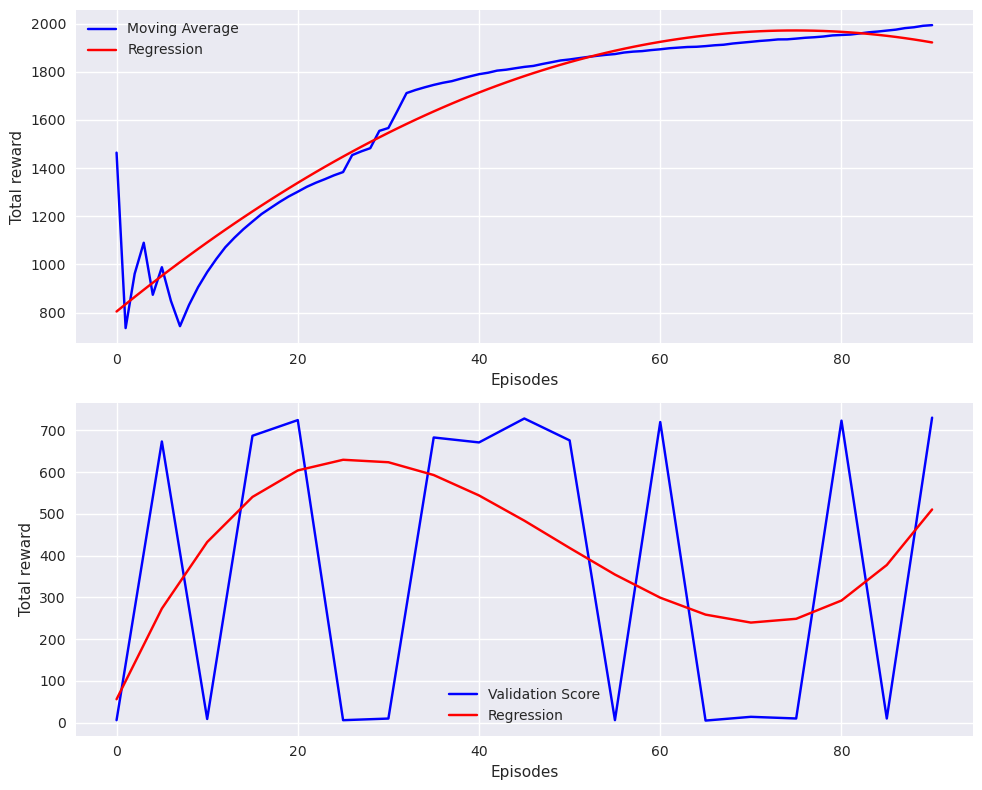

Episode: 0, score: 1464, moving average: 1464, epsilon: 0.76, long ratio: 48.2%, time: 500.45
Episode: 1, score: 7, moving average: 736, epsilon: 0.75, long ratio: 66.7%, time: 3.22
Episode: 2, score: 1413, moving average: 961, epsilon: 0.57, long ratio: 46.8%, time: 532.75
Episode: 3, score: 1476, moving average: 1090, epsilon: 0.43, long ratio: 46.2%, time: 552.84
Episode: 4, score: 10, moving average: 874, epsilon: 0.42, long ratio: 46.2%, time: 4.84
Episode: 5, score: 1561, moving average: 988, epsilon: 0.32, long ratio: 43.6%, time: 566.76
Episode: 6, score: 9, moving average: 848, epsilon: 0.32, long ratio: 34.8%, time: 4.87
Episode: 7, score: 9, moving average: 744, epsilon: 0.32, long ratio: 26.1%, time: 4.53
Episode: 8, score: 1538, moving average: 832, epsilon: 0.24, long ratio: 44.1%, time: 584.07
Episode: 9, score: 1571, moving average: 906, epsilon: 0.18, long ratio: 43.5%, time: 598.40
Episode: 10, score: 1591, moving average: 968, epsilon: 0.13, long ratio: 40.9%, time: 

In [80]:
validation_period = 5
for i in range(n_episodes):
  # start_time = time.time() 

  # observation, score, done = env.reset(), 0, False
  # iteration = 0
  # num_long, num_short = 0, 0
  # while not done:
  #   action = agent.choose_action(observation)
  #   if action == 0:
  #     num_short += 1
  #   elif action == 1:
  #     num_long += 1
  #   observation_, reward, done, info = env.step(action)
  #   score += reward
  #   agent.remember(observation, action, reward, observation_, int(done))
  #   observation = observation_
  #   agent.learn()
  #   if iteration % 100 == 0:
  #     print("\rFinished Learning iteration: {}".format(iteration), end="")
  #   iteration += 1

  # end_time = time.time()  

  # # Bookkeeping
  # scores.append(score)
  # moving_average = np.mean(scores[-25:])
  # moving_average_plot.update(len(moving_average_plot.y_data), moving_average)
  # regression_plot.update(len(regression_plot.y_data), moving_average)
  # training_logs.append(f'\rEpisode: {len(moving_average_plot.y_data)}, score: {score:.0f}, moving average: {moving_average:.0f}, epsilon: {agent.epsilon:.2g}, long ratio: {100*num_long/(num_long+num_short):.1f}%, time: {end_time - start_time:.2f}')

  
  # if i % 10 == 0:
  #   agent.save_model()
  # if i % validation_period == 0:
  #   # Validation
  #   score = validate(agent)
  #   validation_score_plot.update(validation_period*len(validation_score_plot.y_data), score)
  #   validation_regression_plot.update(validation_period*len(validation_regression_plot.y_data), score)

  # Update plots and logs
  clear_output(wait=True) 
  display(fig)
  [print(log, flush=True) for log in training_logs]
  
# The validation dataset has 1395 rows. 
# So getting 50% correct with 1 point each would give a score of ~700

And we can perform a similar plot on the validation set to get a sense of the agent's generalizability.

Next we'll test the agent on our test set.

In [78]:
test_env.reset()

test_scores = []
test_averages = []

observation, score, done = test_env.reset(), 0, False
while not done:
  action = agent.choose_optimal_action(observation)
  observation_, reward, done, info = test_env.step(action)
  score += reward
  observation = observation_
print("")
test_scores.append(score)
test_averages.append(np.mean(test_scores[-25:]))


print(f'score: {score:.2f}, moving average: {test_averages[-1]:.2f}')


score: 749.65, moving average: 749.65


In [81]:
len(test_env.data), len(test_env.data)/2

(1430, 715.0)

## Backesting

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

def backtest(agent, env):
  done = False
  env.data['p'] = 0
  state = env.reset()
  while not done:
    action = np.argmax(agent.q_eval.predict(state[np.newaxis, :], verbose=False))
    position = 1 if action == 1 else -1
    env.data.loc[:, 'p'].iloc[env.bar] = position
    state, reward, done, info = env.step(action)
  env.data['s'] = env.data['p'] * env.data['r']

In [ ]:

backtest(agent, test_env)

/tmp/ipykernel_3959904/2014142642.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  env.data.loc[:, 'p'].iloc[env.bar] = position
/tmp/ipykernel_3959904/2014142642.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pan

In [ ]:
test_env.data['p'].iloc[test_env.lags:].value_counts()

p
 0    1059
-1      17
Name: count, dtype: int64

So we see that the agent goes short roughly half of the time and long the other half of the time.

The line below evaluates the number of trades.

In [ ]:
sum(test_env.data['p'].iloc[test_env.lags:].diff() != 0)

155

In [ ]:
(test_env.data[['r', 's']].iloc[test_env.lags:] * test_env.leverage).sum().apply(np.exp) - 1

r    0.01827
s   -0.11631
dtype: float64

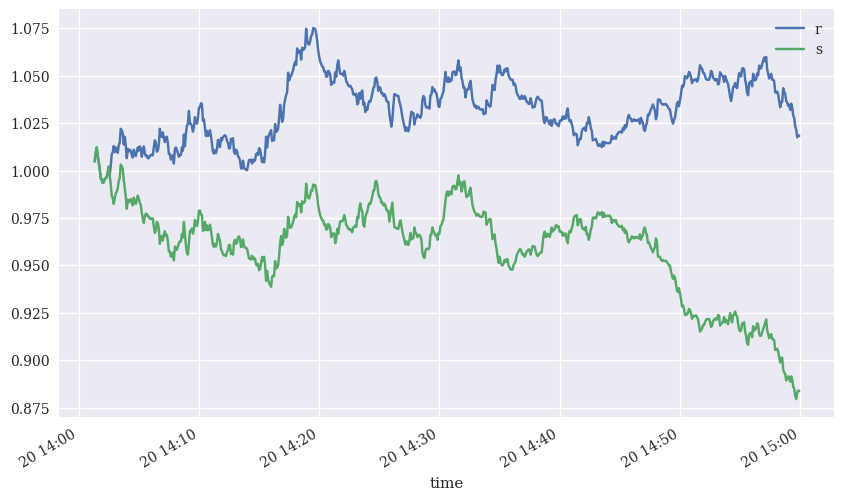

In [ ]:
(test_env.data[['r', 's']].iloc[test_env.lags:] * test_env.leverage).cumsum().apply(np.exp).plot(figsize=(10, 6));

# Deployment

One of the most important aspects of the "deployed" version of our "bot", is that it must take actions in response to the streamed data. To achieve this we create a class that inherits from `tpqoa`, and overwrites the `on_success` method, which gets triggered every time a new item of streamed data is received.

In [59]:
import json
import tpqoa
from datetime import datetime, timedelta
import random
from typing import Optional, Literal, TypedDict
from datetime import datetime, timedelta
import pytz

class LimitOrder(TypedDict):
    id: Optional[int]
    state: Optional[Literal["PENDING", "FILLED", "CANCELLED"]]

class OandaTradingBot(tpqoa.tpqoa) :
  def __init__(self, config_file, agent, granularity, units, verbose=True, init_pl=0.0):
    super(OandaTradingBot, self).__init__(config_file)
    self.init_pl = init_pl
    self.agent = agent
    self.symbol = symbol
    self.env = learn_env
    self.window = self.env.window
    if granularity is None:
      self.granularity = self.env.granularity
    else:
      self.granularity = granularity
    self.units = units
    self.trades = 0
    self.position = 0
    # Get historical data so we can build the features like moving averages
    try:
      end_time = datetime.now(pytz.utc)
      start_time = end_time - timedelta(hours=4)
      start = start_time.strftime('%Y-%m-%d %H:%M:%S')
      end = end_time.strftime('%Y-%m-%d %H:%M:%S')
      print(f"Getting historical data from {start} to {end}")
      mid = api.get_history(instrument='EUR_USD', start=start, end=end, granularity='M1', price='M')
      bid = api.get_history(instrument='EUR_USD', start=start, end=end, granularity='M1', price='B') 
      ask = api.get_history(instrument='EUR_USD', start=start, end=end, granularity='M1', price='A')
      mid.index = mid.index.tz_localize('UTC')
      bid.index = bid.index.tz_localize('UTC')
      ask.index = ask.index.tz_localize('UTC')
      self.tick_data = pd.DataFrame({ 'bid': bid['c'], 'mid': mid['c'], 'ask': ask['c'] }, index=bid.index)
      # print(self.tick_data)
      self._resample_data()
      self.min_length = max(len(self.data),self.env.window + self.env.lags)
    except:
      self.tick_data = pd.DataFrame()
      self.min_length = (self.env.window + self.env.lags)
    # If 'tick_data.csv' exists, read it, else initialize new dataframe
    # if os.path.exists('tick_data.csv'):
    #   self.tick_data = pd.read_csv('tick_data.csv', index_col=0, parse_dates=True) 
    #   self._resample_data()
    #   self.min_length = len(self.data)
    # else:
    #   self.tick_data = pd.DataFrame()
    #   self.min_length = (self.env.window + self.env.lags)
    self.pl = list()
    self.previous_net_pl = 0.0
    self.verbose = verbose
    self.count = 0
    self.trading_logs = []
    self.limit_order: LimitOrder = {
      "id": None,
      "state": None
    } 

  def _prepare_data(self):
    self.data['r'] = np.log(self.data / self.data.shift(1))
    self.data.dropna(inplace=True)
    self.data['s'] = self.data[self.symbol].rolling(self.window).mean()
    self.data['m'] = self.data['r'].rolling(self.window).mean()
    self.data['v'] = self.data['r'].rolling(self.window).std()
    self.data.dropna(inplace=True)
    # Normalize the data
    self.data_ = (self.data - self.env.mu) / self.env.std

  def _resample_data(self):
    self.data = self.tick_data.resample(self.granularity, label='right').last().ffill().iloc[:-1]
    self.data = pd.DataFrame(self.data['mid'])
    self.data.columns = [self.symbol,]
    self.data.index = self.data.index.tz_localize(None)
    # Save to disk in case it is useful later
    if len(self.tick_data) != 0 and len(self.tick_data) % 100 == 0:
      self.tick_data.to_csv('tick_data.csv')

  def _get_state(self):
    state = self.data_[self.env.features].iloc[-self.env.lags:]
    return np.reshape(state.values, [1, self.env.lags, self.env.n_features])
  
  def report_trade(self, time, side, order, price):
    if order['type'] == 'LIMIT_ORDER_REJECT':
      print(order)
    else:
      self.trades += 1
      net_pl = float(self.get_account_summary()['pl']) - self.init_pl
      pl = net_pl - self.previous_net_pl
      self.pl.append(pl)
      self.trading_logs.append(f'{time} | *** GOING {side} ({self.trades}) *** | PROFIT/LOSS={pl:.2f} | Cumulative={net_pl:.2f} | Order Price: {price}')
      self.previous_net_pl = net_pl
      if self.verbose:
        pprint(order)
        print(80 * '=')

  def cancel_limit_order(self):
    response =  self.cancel_order(self.limit_order['id'])
    if 'orderCancelRejectTransaction' in response:
      print("cancel_limit_order_response", response)
      if response['orderCancelRejectTransaction']['rejectReason'] == 'ORDER_DOESNT_EXIST':
        # If the order doesn't exist, then it was either filled or cancelled and the update wasn't yet picked up
        self.update_limit_order_state()
        if self.limit_order['state'] == "FILLED":
          self.create_order(self.symbol, units=-self.position * self.units, suppress=True, ret=True)
        elif self.limit_order['state'] == "CANCELLED":
          self.limit_order = { "id": None, "state": None }
    else:
      self.limit_order = { "id": None, "state": None }
      

  def update_limit_order_state(self):
    if self.limit_order['state'] == "PENDING":
      response = json.loads(self.ctx.order.get(self.account_id,self.limit_order['id']).raw_body)
      if 'errorCode' in response:
        # print("update_limit_order_state", response, self.limit_order)
        if response['errorCode'] == 'NO_SUCH_ORDER':
          # Check if any of the most recent transactions corresponds to this order. 
          # If one does, then the order has been filled.
          for t in self.get_transactions(tid=int(response['lastTransactionID'])-3):
            if t.get('id') == str(self.limit_order['id']):
              print(f"Limit order {self.limit_order['id']} filled")
              # t['type'] == 'ORDER_FILL'
              self.limit_order['state'] = "FILLED"
              break
            else:
              pass
        else:
          print("errorCode was not 'NO_SUCH_ORDER'",f"{response['errorCode']=}")
      elif 'order' in response:
        print(f"{response['order']=}")
        if response['order']['state'] == 'PENDING':
          pass
        elif response['order']['state'] == 'CANCELLED':
          print(f"Limit order {self.limit_order['id']} cancelled")
          self.limit_order['state'] = "CANCELLED"
        elif response['order']['state'] == 'FILLED':
          print(f"Limit order {self.limit_order['id']} filled")
          self.limit_order['state'] = "FILLED"
      else:
        print("Neither 'errorCode' nor 'order' in response:", json.dumps(response))

  def on_success (self, time, bid, ask):
    self.count += 1
    new_row = pd.DataFrame({'ask': ask, 'bid': bid, 'mid': (bid + ask) / 2}, index=[pd.Timestamp(time)])
    self.tick_data = pd.concat([self.tick_data, new_row])
    self._resample_data()
    condition = len(self.data) > self.min_length
    print(f"\rcount: {self.count}, ticks: {len(self.data)}, min_length: {self.min_length}", end='\n' if condition else '', flush=True)
    if condition:
      self.min_length += 1
      self._prepare_data ()
      state = self._get_state()[0]
      prediction = self.agent.choose_optimal_action(state)
      print(f'{datetime.fromisoformat(time[:26]).strftime("%H:%M")} | PREDICTION={prediction}')
      signal = 1 if prediction == 1 else -1
      # signal = 1 if random.random() <= 0.1 else -1
      if self.position in [0, -1] and signal == 1:
        price=f"{float(new_row['ask'].iloc[0]):.5f}"
        order = self.create_order(self.symbol, units=self.units, price=price, suppress=True, ret=True)
        print("Order state", self.limit_order['state'])
        if self.limit_order['state'] == "FILLED":
          # Create a market order to immediatley close the position
          self.create_order(self.symbol, units=-self.position * self.units, suppress=True, ret=True)
        elif self.limit_order['state'] == "PENDING":
          self.cancel_limit_order()
        self.limit_order = {
          "id": int(order['id']),
          "state": "PENDING",
        }
        print("new limit order", self.limit_order)
        # order = self.create_order(self.symbol, units=(1 - self.position) * self.units, suppress=True, ret=True)
        self.report_trade(time, 'LONG', order, price),  
        self.position = 1
        print(self.trading_logs[-1], flush=True)
      elif self.position in [0, 1] and signal == -1:
        price=f"{float(new_row['bid'].iloc[0]):.5f}"
        order = self.create_order(self.symbol, units=-self.units, price=price, suppress=True, ret=True)
        print("Order state", self.limit_order['state'])
        if self.limit_order['state'] == "FILLED":
          # Create a market order to immediatley close the position
          self.create_order(self.symbol, units=-self.position * self.units, suppress=True, ret=True)
        elif self.limit_order['state'] == "PENDING":
          self.cancel_limit_order()
        self.limit_order = {
          "id": int(order['id']),
          "state": "PENDING",
        }
        print("new limit order", self.limit_order)
        # order = self.create_order(self.symbol, units=-(1 + self.position) * self.units, suppress=True, ret=True)
        self.report_trade(time, 'SHORT', order, price)
        self.position = -1
        print(self.trading_logs[-1], flush=True)
    else:
      self.update_limit_order_state()

In [160]:
import time
import v20

# Set to True if initializing a new bot
if True:
  otb = OandaTradingBot('../oanda.cfg', agent, '5min', 25000, verbose=False, init_pl=float(api.get_account_summary()['pl']))


start = time.time()
while True:
  # stream is run in a while loop so that it is resilient to timeout errors
  if time.time() < start + 5 * 60:
    try:
      otb.stream_data(symbol, stop=40)
    except v20.errors.V20ConnectionError as e:
      print(f"Stream timeout")
  else:
    break 


print('\n' + 80 * '=')
if otb.position * otb.units != 0:
  print('*** CLOSING OUT ***')
  print(otb.symbol, -otb.position * otb.units)
  price = float(otb.tick_data['ask'].iloc[-1])
  order = otb.create_order(otb.symbol, units=-otb.position * otb.units, price=price, suppress=True, ret=True)
  otb.report_trade(otb.tick_data.index[-1], 'NEUTRAL', order, price)
  if otb.verbose:
    pprint(order)
  print(80 * '=')

Getting historical data from 2024-07-01 11:11:03 to 2024-07-01 15:11:03
count: 320, ticks: 49, min_length: 48
15:15 | PREDICTION=1
Order state None
new limit order {'id': 2220, 'state': 'PENDING'}
2024-07-01T15:15:01.332628064Z | *** GOING LONG (1) *** | PROFIT/LOSS=0.00 | Cumulative=0.00 | Order Price: 1.07236
count: 321, ticks: 49, min_length: 49Limit order 2220 filled
15:25 | PREDICTION=0
Order state FILLED
new limit order {'id': 2222, 'state': 'PENDING'}
2024-07-01T15:25:00.075692687Z | *** GOING SHORT (2) *** | PROFIT/LOSS=-1.79 | Cumulative=-1.79 | Order Price: 1.07227
count: 977, ticks: 51, min_length: 51Limit order 2222 filled
count: 1241, ticks: 52, min_length: 51
15:30 | PREDICTION=1
Order state FILLED
new limit order {'id': 2226, 'state': 'PENDING'}
2024-07-01T15:30:00.061765690Z | *** GOING LONG (3) *** | PROFIT/LOSS=0.40 | Cumulative=-1.39 | Order Price: 1.07229
count: 1242, ticks: 52, min_length: 52Limit order 2226 filled
count: 1946, ticks: 55, min_length: 54
15:45 | PRE

# Performance Analysis

In [158]:
pl = np.array(otb.pl)
pl

array([ 0.    , -1.7891,  0.3976, -1.5902, -6.7575, -2.7537,  9.7309,
        2.7796,  3.1773, -2.9789,  4.3304, -1.5905,  0.5906, -4.9712,
       10.5341,  3.5414, -8.3469,  0.7869, -2.3845,  0.1967, -1.3908,
        4.5236, -1.7879,  1.3767,  2.9502, -0.7945,  1.7696, -5.1646,
        7.1512,  3.7742,  0.5959, -1.1919,  9.6435, -0.9938, -0.3976,
       -0.9941,  4.5717, -3.1804,  0.7951, -3.1806, -1.3916,  0.3936,
       -1.5906,  0.5905,  1.3917, -6.9603,  3.7783,  4.5742, -0.5966,
        0.3938, -2.3862, -1.3919,  3.544 , -3.5799])

In [159]:
pl.cumsum()

array([  0.    ,  -1.7891,  -1.3915,  -2.9817,  -9.7392, -12.4929,
        -2.762 ,   0.0176,   3.1949,   0.216 ,   4.5464,   2.9559,
         3.5465,  -1.4247,   9.1094,  12.6508,   4.3039,   5.0908,
         2.7063,   2.903 ,   1.5122,   6.0358,   4.2479,   5.6246,
         8.5748,   7.7803,   9.5499,   4.3853,  11.5365,  15.3107,
        15.9066,  14.7147,  24.3582,  23.3644,  22.9668,  21.9727,
        26.5444,  23.364 ,  24.1591,  20.9785,  19.5869,  19.9805,
        18.3899,  18.9804,  20.3721,  13.4118,  17.1901,  21.7643,
        21.1677,  21.5615,  19.1753,  17.7834,  21.3274,  17.7475])

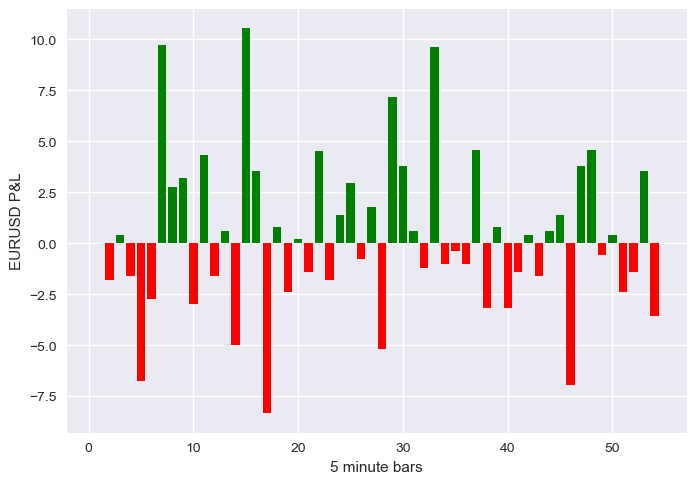

In [151]:
%matplotlib inline
plt.bar(np.arange(1,len(pl)+1 ), pl, color=['g' if p > 0 else 'r' for p in pl])
plt.ylabel("EURUSD P&L")
plt.xlabel("5 minute bars")
plt.show()

Text(0.5, 0, '5 minute bars')

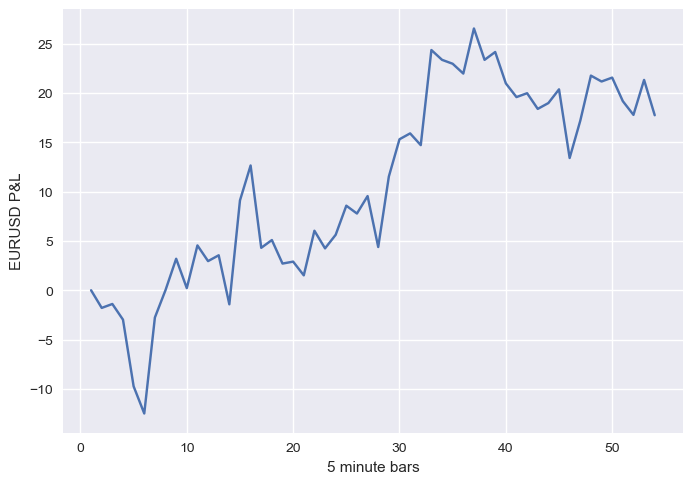

In [152]:
plt.plot(np.arange(1, len(pl)+1), pl.cumsum())
plt.ylabel("EURUSD P&L")
plt.xlabel("5 minute bars")
